
---
<h3 align = center>  </h3>

---
<h3 align = center> CS156 </h3>

---
<h2 align = center> Second Pipeline: Accent Classification using Data Augmentation and CNNs </h2>
<h3 align = center> Prof. P. Watson </h3>
<h3 align = center> 27/03/2024 </h3>

---

## Previous work:
In the first assignment, I used 5 numerical audio features to create two ML models - Logistic regression and Random Forest - that differentiate between Argentinian Accents and Other Accents. After Hyperparameter tuning and
cross-validation of the logistic regression model achieved a test accuracy of 62% and the RF model achieved a test accuracy of 82%.

## What's new in this assignment?

Based on the feedback from the last assignment I have increased the training data to an order of 10^3 by chopping the clips into 2 seconds (previously it was 5) and have used CNN and RNN (LSTM) based ML models to classify the audio clips into "Argentinian" and "Other" Accent by converting the audio clips into MFCCs (Mel-frequency cepstral coefficients). I also moved everything to GoogleColab from Jupyter notebook and uploaded and modified my data on Google Drive.



In [210]:
from google.colab import drive
drive.mount('/content/drive')

In [80]:
import librosa
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pydub import AudioSegment
from scipy.io import wavfile
from librosa.core import resample, to_mono
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tqdm import tqdm
from python_speech_features import mfcc, logfbank
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from imblearn.under_sampling import RandomUnderSampler
from keras import regularizers
from tqdm.keras import TqdmCallback
from keras.optimizers import Adam

# Environmental variable to hide unnecessary output
os.environ['MKL_DEBUG_CPU_TYPE'] = '5'

## 1: DATA COLLECTION:
I have used the same data that I used in the first assignment.

##2 & 3: Data Pre-processing and Feature Engineering
1. I modified my initial code used in first assignment to chop the audio clips into 2 seconds each then stored them in the AUDIOCLIPS folder in my google drive.

### Code to chop audio files into 2 second sub clips

In [7]:
def chop_wav_to_subclips(source_folder, target_folder, clip_length_ms=2000):
    # Ensure the target folder exists
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Retrieve the list of .wav files in the source folder
    filenames = [f for f in os.listdir(source_folder) if f.endswith('.wav')]

    # Process each .wav file in the source folder
    for filename in tqdm(filenames, desc="Processing audio files"):
        wav_path = os.path.join(source_folder, filename)
        audio = AudioSegment.from_wav(wav_path)

        # Calculate the number of 2-second chunks
        n_chunks = len(audio) // clip_length_ms
        for i in range(n_chunks):
            # Calculate start and end times
            start_time = i * clip_length_ms
            end_time = start_time + clip_length_ms
            # Extract the subclip
            subclip = audio[start_time:end_time]
            # Format the subclip filename
            subclip_name = f"{filename[:-4]}_{i+1:02d}.wav"
            subclip_path = os.path.join(target_folder, subclip_name)
            # Export subclip
            subclip.export(subclip_path, format="wav")

# Update these paths to point to the locations on your Google Drive
source_folder = '/content/drive/MyDrive/CS156DATA/ORIGINALDATA'  # Corrected path
target_folder = '/content/drive/MyDrive/CS156DATA/AUDIOCLIPS'

# Run the function
chop_wav_to_subclips(source_folder, target_folder)

Processing audio files: 100%|██████████| 11/11 [04:51<00:00, 26.54s/it]


2. I wrote code to create a .csv file that stores the name of each audio clip with its label. This was later used to keep track of audioclips' label when they were used to data augmentation.
### Code to create database file for the sub clips with labels

In [8]:
import os
import pandas as pd
from tqdm import tqdm  # Import tqdm

def create_labels_csv(audio_folder, target_folder):
    # Ensure the target folder exists
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Initialize the list to hold data
    data = []

    # Get a list of all .wav files in the directory
    wav_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]

    # Process each file in the directory
    for filename in tqdm(wav_files, desc="Processing WAV files"):  # Use tqdm here
        # Check if 'Argentinian' or 'Other' is in the filename
        if 'Argentinian' in filename:
            label = 'Argentinian'
        elif 'Other' in filename:
            label = 'Other'
        else:
            continue  # If neither is found, skip the file

        # Append the data to the list
        data.append({'index': len(data), 'fname': filename, 'label': label})  # Use len(data) as index

    # Create a DataFrame from the data list
    df = pd.DataFrame(data)

    # Save the DataFrame to a CSV file in the target folder
    csv_file_path = os.path.join(target_folder, 'audio_files_labels.csv')
    df.to_csv(csv_file_path, index=False)

# Update these paths to point to the locations on your Google Drive
audio_folder = '/content/drive/MyDrive/CS156DATA/AUDIOCLIPS'  # Update to your Google Drive source folder path
target_folder = '/content/drive/MyDrive/CS156DATA/AUDIOLABELS'  # Update to your Google Drive target folder path

# Run the function
create_labels_csv(audio_folder, target_folder)

Processing WAV files: 100%|██████████| 570/570 [00:00<00:00, 560289.03it/s]


In [215]:
df = pd.read_csv(os.path.join(target_folder, 'audio_files_labels.csv'))
df.head()

,index,fname,label
0,0,Other5_01.wav,Other
1,1,Other5_02.wav,Other
2,2,Other5_03.wav,Other
3,3,Other5_04.wav,Other
4,4,Other5_05.wav,Other


## MFFCs (Mel Frequency Cepstral Coefficients )

The audio feature that I used to train the CNN and RNN models are MFCCs. MFCCs are a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear Mel scale of frequency. The Mel scale is an approximation of the human ear's response to different frequencies, emphasizing more on the components that are perceptually important to humans. The process of computing MFCCs involves several steps:

1. Frame the signal into short frames: The audio signal is divided into short, overlapping frames to assume stationary audio signals within these frames.
2. Apply the Fourier transform: This step converts each frame from time domain to frequency domain.
3. Map to the Mel scale: The power spectrum is then mapped onto the Mel scale using a set of triangular filters.
4. Take the logarithm: This step aims to mimic the human ear's logarithmic response.
5. Apply the Discrete Cosine Transform (DCT): This step converts the log Mel spectrum into time domain, giving the final set of MFCCs.

## Code to visualise the MFCCs along with Mel Spectogram and Raw Audio Time Series

Argentinian: Argentinian4_01.wav
Other: Other5_01.wav


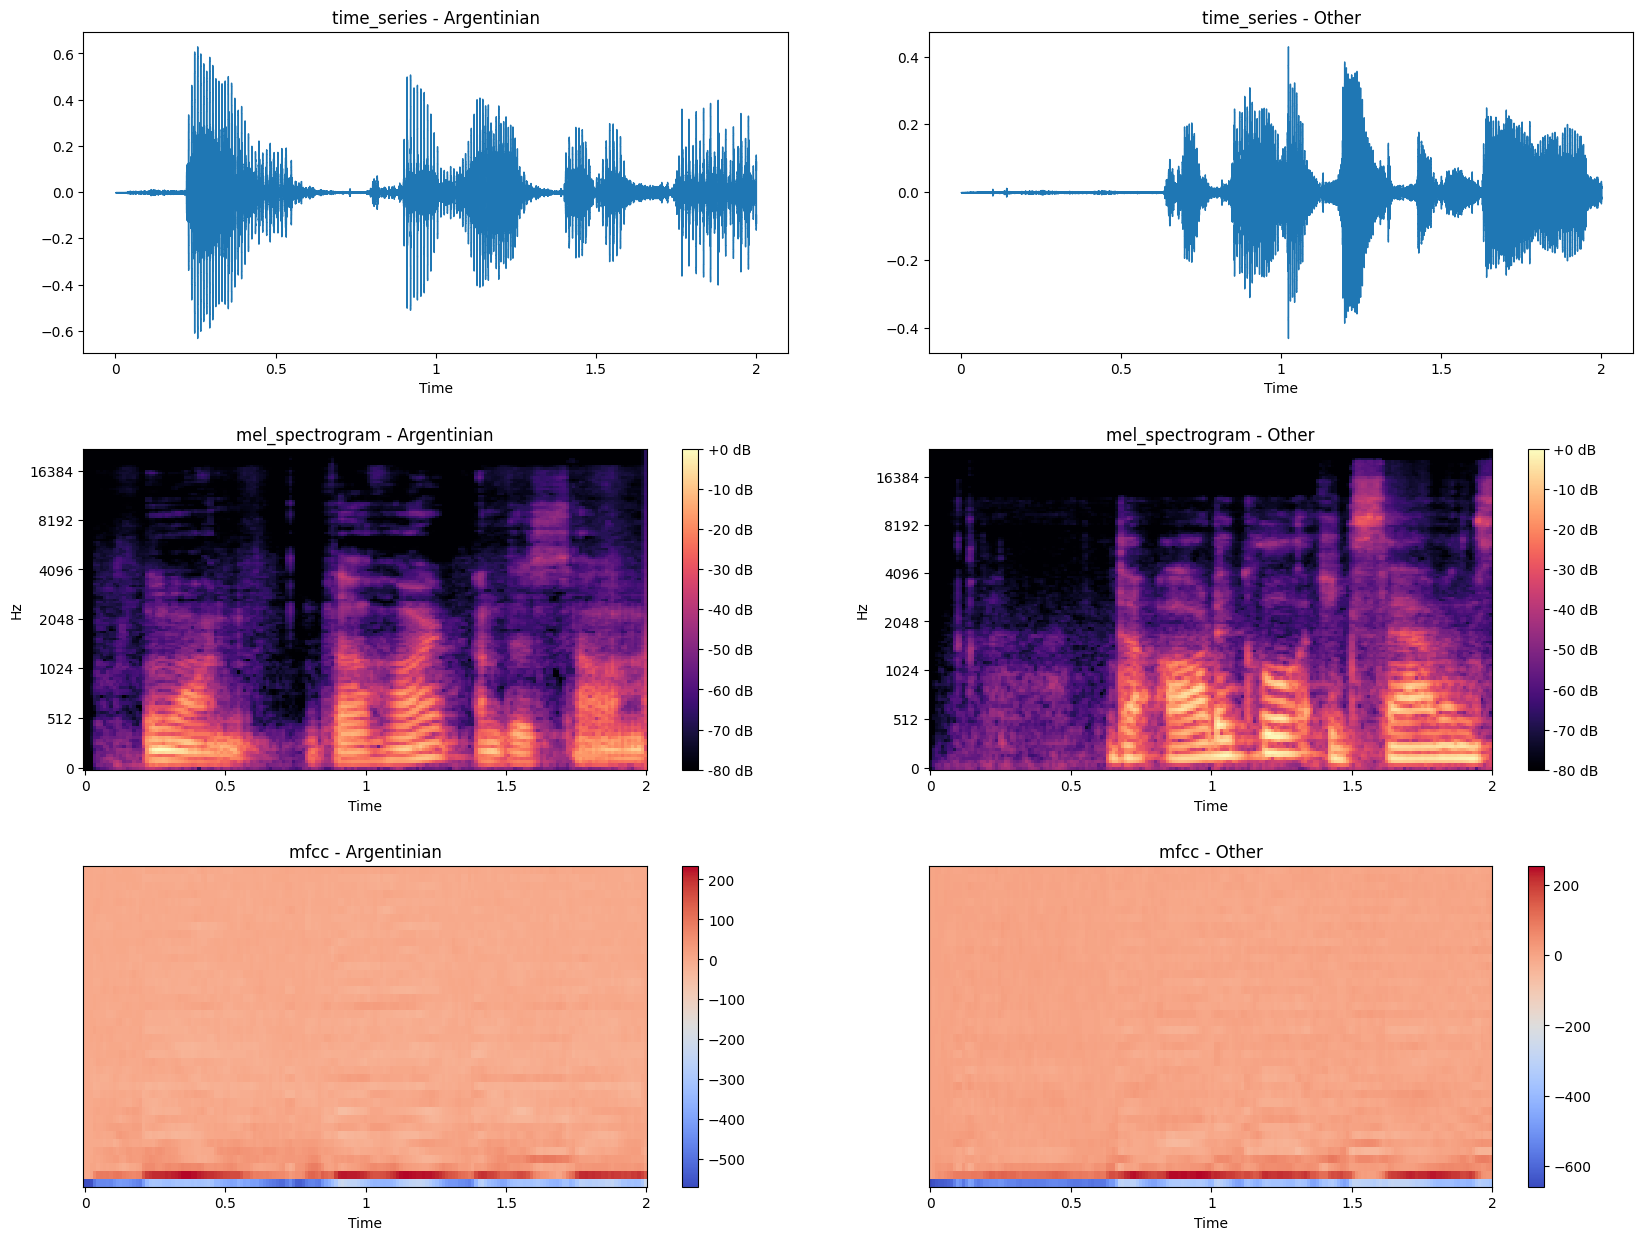

In [9]:
def plot_time_series(ax, signal, sr, title='Time Series'):
    librosa.display.waveshow(signal, sr=sr, ax=ax)
    ax.set_title(title)

def plot_mel_spectrogram(ax, signal, sr, title='Mel Spectrogram'):
    S = librosa.feature.melspectrogram(y=signal, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', ax=ax)
    ax.figure.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set_title(title)

def plot_mfcc(ax, signal, sr, title='MFCC'):
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
    img = librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax)
    ax.figure.colorbar(img, ax=ax)
    ax.set_title(title)

def load_and_plot(audio_folder, target_folder):
    # Load the labels CSV
    df = pd.read_csv(os.path.join(target_folder, 'audio_files_labels.csv'))

    # Prepare the figure with subplots, ensuring consistent subplot sizes
    fig, axs = plt.subplots(3, 2, figsize=(20, 15),
                            gridspec_kw={'hspace': 0.3, 'wspace': 0.2})  # Adjust spacing as needed

    # Find one example from each class
    for i, label in enumerate(['Argentinian', 'Other']):
        filename = df[df['label'] == label].iloc[0]['fname']
        signal, sr = librosa.load(os.path.join(audio_folder, filename), sr=None)

        print(f"{label}: {filename}")

        # Call each plot function with the appropriate subplot axis
        for j, plot_func in enumerate([plot_time_series, plot_mel_spectrogram, plot_mfcc]):
            plot_func(axs[j, i], signal, sr, title=f'{plot_func.__name__[5:]} - {label}')
    plt.show()

# Assuming the paths are correctly set to your Google Drive locations
audio_folder = '/content/drive/MyDrive/CS156DATA/AUDIOCLIPS'
target_folder = '/content/drive/MyDrive/CS156DATA/AUDIOLABELS'

load_and_plot(audio_folder, target_folder)



## 4: Discussing the task
The task remains the same as the first assignment - binary classification of the Argentinian accent from the Other accent class. The difference if that now we are usign MFCCs images of the audio clips to make the classification using a CNN and RNN model


## 5,6 & 7: Experiments and Models

##Experiment 1: Using the CNN model without data augmentation

We converted our audio data into images usign MFCCs. Given now we have image representation of the audio data we can use a CNN (Convolutional Neural Network) model to classify the audio clips into the Argentinian and Other Accent class.

Convolutional Neural Networks (CNNs) are a class of deep learning models primarily used for processing data with grid-like topology, such as images. CNNs are distinguished by their use of convolutional layers, which apply filters to their input to create feature maps, highlighting important features without fully connecting every unit. This architecture enables efficient processing and reduced computational cost by leveraging spatial hierarchies in data. CNNs typically include pooling layers to reduce dimensionality and fully connected layers for classification. They excel in tasks like image and speech recognition due to their ability to learn complex patterns and features from data.

The model architecture used in the model below is sequential, meaning layers are stacked linearly.

**Conv2D Layer:** The first layer is a 2D convolutional layer with 64 filters, each of size 3x3 pixels. This layer's role is to extract features from the input images by applying each filter across the image and producing 64 feature maps. The 'relu' activation function introduces non-linearity, allowing the model to learn complex patterns. The input shape is specified to match the dimensions of the training data, ensuring that the model knows the size of images it's processing.

**MaxPooling2D Layer:** Following the convolutional layer is a max pooling layer with a 2x2 window size. This layer reduces the spatial dimensions (height and width) of the feature maps by taking the maximum value in each 2x2 area of the feature maps. This operation reduces the amount of computational resources needed for the next layers and helps prevent overfitting by abstracting the features.

**Dropout Layer (0.10):** The first dropout layer randomly sets 10% of the input units to 0 at each step during training, which helps prevent overfitting by ensuring that the model does not rely too heavily on any one node.

**Flatten Layer:** This layer flattens the feature maps from the max pooling layer into a single long vector. It transforms the 2D matrix data into a format that can be used by the dense layers that follow.

**Dense Layer:** A fully connected layer that has 128 neurons and uses 'relu' activation. This layer takes the flattened feature vectors as input and continues the pattern recognition process, with each neuron learning to activate for specific patterns in the data.

**Dropout Layer (0.20):** Another dropout layer, but this time it sets 20% of the input units to 0, further aiding in preventing overfitting.

**Dense Output Layer:** The final layer is another fully connected (dense) layer but with only 2 neurons, each corresponding to one of the binary classes. The 'sigmoid' activation function is used to output probabilities that sum to 1, making the final output suitable for binary classification.

### Loss Function:

The CNN model above uses the binary cross-entropy loss function, which is commonly used for binary classification tasks. This loss function measures the performance of a classification model whose output is a probability value between 0 and 1. Binary cross-entropy loss is calculated for each example in the dataset, and the final loss is the average of these individual losses.

Mathematically, the binary cross-entropy loss for a single example is defined as:

$$ L(y, \hat{y}) = -\left( y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}) \right) $$

Where:

L(y,ŷ ) is the loss for a single example.

y is the actual label of the example, which can be either 0 or 1.

ŷ  is the predicted probability that the example belongs to class 1, as output by the model.

The term ylog(ŷ ) accounts for the loss when the actual label is 1, and the term (1-y) log(1-ŷ ) accounts for the loss when the actual label is 0. The negative sign ensures that the loss is a positive number.

For a dataset with N examples, the total binary cross-entropy loss is the sum of the individual losses over all examples, divided by N \) (i.e., the average loss):

$$ L_{\text{total}} = -\frac{1}{N} \sum_{i=1}^{N} \left( y_i \log(\hat{y_i}) + (1 - y_i) \log(1 - \hat{y_i}) \right) $$

This loss function is effective for binary classification because it penalizes predictions that are confidently wrong more heavily than predictions that are less confident, encouraging the model to output probabilities that accurately reflect the true likelihood of the input belonging to class 1. The goal of training is to minimize this loss, leading to a model that makes accurate predictions on the training data.

##Code for the CNN model


In [236]:
from keras import regularizers
from tqdm.keras import TqdmCallback


# Function to extract MFCC features from the dataset
def extract_features(df, audio_folder):
    X = []
    y = []
    for index, row in df.iterrows():
        file_path = os.path.join(audio_folder, row["fname"])
        label = row["label"]
        signal, sample_rate = librosa.load(file_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40)
        X.append(mfccs)
        y.append(1 if label == 'Argentinian' else 0)
    return np.array(X), np.array(y)

# Load the dataset and extract features
audio_folder = '/content/drive/MyDrive/CS156DATA/AUDIOCLIPS/'
df = pd.read_csv('/content/drive/MyDrive/CS156DATA/AUDIOLABELS/audio_files_labels.csv')
X, y = extract_features(df, audio_folder)

# Reshape the data for CNN input
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

# Define the undersampler
undersample = RandomUnderSampler(random_state=42)

# Flatten X for undersampling, then reshape it back after undersampling
X_flat = X.reshape(X.shape[0], -1)
X_resampled, y_resampled = undersample.fit_resample(X_flat, y)
X_resampled = X_resampled.reshape(X_resampled.shape[0], X.shape[1], X.shape[2], 1)

# One-hot encode the labels
y_resampled = to_categorical(y_resampled, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

# Define a CNN model without regularization
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.10))
model.add(Flatten())
model.add(Dense(128, activation='relu'))  # Removed the kernel_regularizer argument
model.add(Dropout(0.20))
model.add(Dense(2, activation='sigmoid'))  # Output layer

# Specify the learning rate
learning_rate = 0.00001  # Example learning rate

# Instantiate the optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Visual representation of the layers in the CNN

In [238]:
import visualkeras
visualkeras.layered_view(model, legend=True,scale_xy=2)
print(X_train.shape)

(361, 40, 63, 1)


## Model Training and Evaluation
I trained the CNN model on 361 MFFC images. Epoch size of 50 and batch size of 16 was used after some trial and error. As we can be from the accuracy and validation loss graph, our CNN model improves with time.

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Test loss: 0.12796050310134888
Test accuracy: 0.9504132270812988


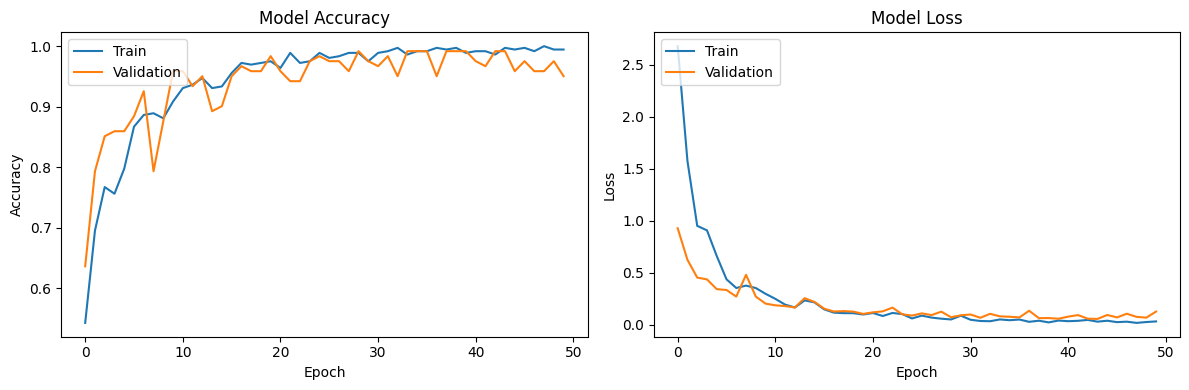

In [234]:
# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=50,
    shuffle=True,
    validation_data=(X_test, y_test),
    verbose=0,  # Turn off the progress bar for cleaner output
    callbacks=[TqdmCallback(verbose=1)]  # Use TqdmCallback for progress bar
)

# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Prediction and Performance Metric

The CNN model performed really good with test accuracy of ~95% and Test loss of ~0.12 even with a small sample size. The model also has perfect precision and 90% recall performance. It is important to note that as we can see from the Model accuracy graph above there is some difference in train and test accuracy which is an indication on overfitting but since the difference is not very large we can say that our model performed well.

4/4 [==============================] - 0s 4ms/step


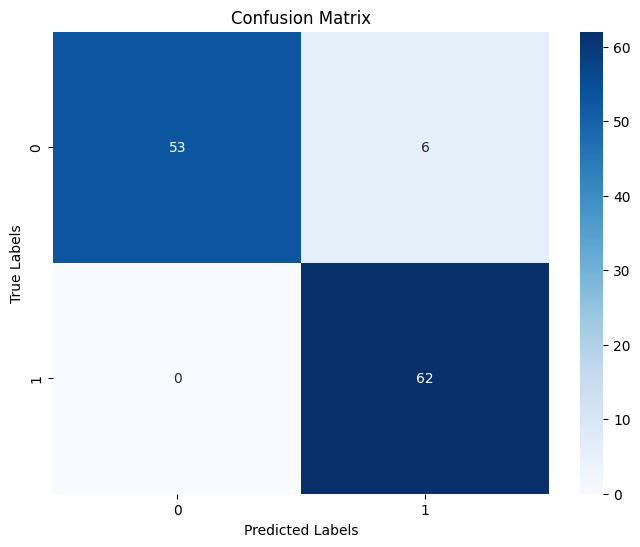

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        59
           1       0.91      1.00      0.95        62

    accuracy                           0.95       121
   macro avg       0.96      0.95      0.95       121
weighted avg       0.95      0.95      0.95       121



In [235]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'model' is your trained Keras model and X_test, y_test are your data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print the classification report
print(classification_report(y_true_classes, y_pred_classes))


##Experiment 2: CNN model with Data Augmentation

To increase the training data of the model I used 4 data augmentation techniques that can modify either the audio clips or the MFCCs features of the original audio clips to increase the size of our training data. The functions are gaussian noise, pith shift, time_mask and frequency mask.These functions apply different types of data augmentation to audio signals. Gaussian noise introduces randomness, simulating recording imperfections. Pitch shifting alters the signal's pitch, imitating different vocal or instrumental tones. Time masking obscures segments of the signal, mimicking occlusions or cuts. Frequency masking silences certain frequency bands, replicating the effect of frequency-specific dampening or losses.

Note that we only use data augmentation for training data to prevent data leakage and maintain a robust test accuracy as we do not encounter the augmented data in real life.

The size of the training set increased to 1281 samples after data augmentation.

In [239]:
def add_gaussian_noise(signal, noise_level=0.005):
    noise = np.random.randn(len(signal))
    augmented_signal = signal + noise_level * noise
    return augmented_signal

def pitch_shift(signal, sr=16000, n_steps=4):
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=n_steps)

def time_mask(signal, mask_length=1000):
    new_signal = signal.copy()
    start = np.random.randint(0, len(signal) - mask_length)
    new_signal[start:start + mask_length] = 0
    return new_signal
def frequency_mask(mfccs, mask_length=2):
    new_mfccs = mfccs.copy()
    start_band = np.random.randint(0, mfccs.shape[0] - mask_length)
    new_mfccs[start_band:start_band + mask_length, :] = 0
    return new_mfccs

## Code for adding augmented data into our training data set.

In [240]:
from sklearn.model_selection import train_test_split
import librosa
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from keras.utils import to_categorical

# Assuming the presence of functions for augmentation like `add_gaussian_noise`, `pitch_shift`, `time_mask`, and `frequency_mask`

def load_audio(file_path, sr=16000):
    signal, _ = librosa.load(file_path, sr=sr)
    return signal

def augment_audio(signal, sr=16000):
    # Apply Gaussian noise
    noise_signal = add_gaussian_noise(signal)

    # Apply Pitch Shift
    pitch_shifted_signal = pitch_shift(signal, sr=sr, n_steps=4)

    # For Time Masking & Frequency Masking, first convert signal to a spectrogram or MFCCs
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)

    # Now you can apply time masking and frequency masking on MFCCs
    # Note: This example directly applies the functions, make sure to adjust them to work on MFCCs
    # This might involve redesigning the augment_audio function to handle MFCCs directly or adjust the logic accordingly

    return [noise_signal, pitch_shifted_signal]  # Return the augmented signals; omitting time and frequency masks for simplicity


# Load dataset and split filenames into training and test sets
df = pd.read_csv('/content/drive/MyDrive/CS156DATA/AUDIOLABELS/audio_files_labels.csv')
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

# Placeholder for augmented data
X_train_augmented = []
y_train_augmented = []

# Process training data, apply augmentations, and extract features
for _, row in train_df.iterrows():
    file_path = os.path.join(audio_folder, row["fname"])
    label = 1 if row["label"] == 'Argentinian' else 0
    signal = load_audio(file_path)

    # Original audio to MFCC
    mfccs = librosa.feature.mfcc(y=signal, sr=16000, n_mfcc=40)
    X_train_augmented.append(mfccs.reshape(mfccs.shape[0], mfccs.shape[1], 1))
    y_train_augmented.append(label)

    # Augmentations
    augmented_signals = augment_audio(signal)
    for augmented_signal in augmented_signals:
        augmented_mfccs = librosa.feature.mfcc(y=augmented_signal, sr=16000, n_mfcc=40)
        X_train_augmented.append(augmented_mfccs.reshape(augmented_mfccs.shape[0], augmented_mfccs.shape[1], 1))
        y_train_augmented.append(label)

# Convert to numpy arrays
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = to_categorical(np.array(y_train_augmented), num_classes=2)

# Process test data and extract features (without augmentation)
X_test = []
y_test = []
for _, row in test_df.iterrows():
    file_path = os.path.join(audio_folder, row["fname"])
    label = 1 if row["label"] == 'Argentinian' else 0
    signal = load_audio(file_path)
    mfccs = librosa.feature.mfcc(y=signal, sr=16000, n_mfcc=40)
    X_test.append(mfccs.reshape(mfccs.shape[0], mfccs.shape[1], 1))
    y_test.append(label)

X_test = np.array(X_test)
y_test = to_categorical(np.array(y_test), num_classes=2)

X_train = X_train_augmented
y_train = y_train_augmented

## Code for CNN model training with Augmented training set

In [241]:
# Define a CNN model without regularization
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(128, activation='relu'))  # Removed the kernel_regularizer argument
model.add(Dropout(0.30))
model.add(Dense(2, activation='sigmoid'))  # Output layer

# Specify the learning rate
learning_rate = 0.00001  # Example learning rate

# Instantiate the optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## Code for CNN model training with Augmented Data

This model was trained on same hyperparameters as the CNN model without augmented data.

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Test loss: 0.29280006885528564
Test accuracy: 0.9300699234008789


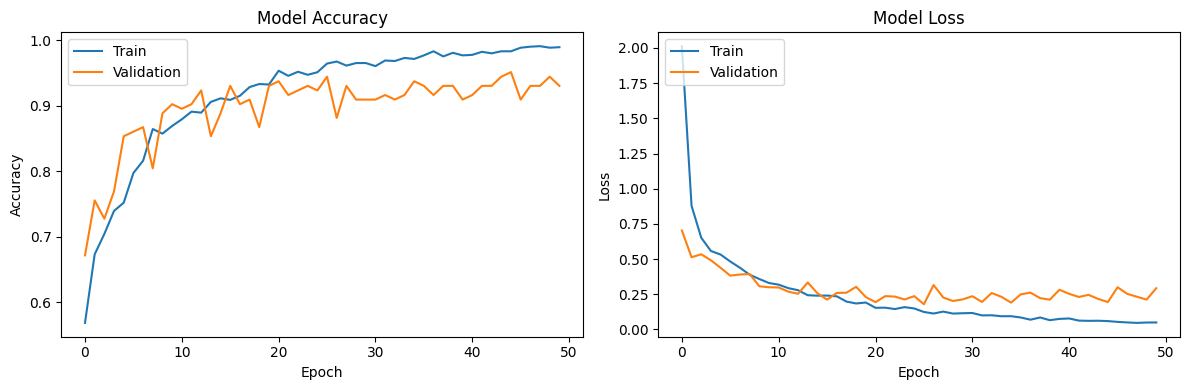

In [242]:
# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=50,
    shuffle=True,
    validation_data=(X_test, y_test),
    verbose=0,  # Turn off the progress bar for cleaner output
    callbacks=[TqdmCallback(verbose=1)]  # Use TqdmCallback for progress bar
)

# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Code for CNN model predictions with Augmented Data

The CNN model with augmented data also showed decent performance with test accuracy of 93% but again we can see the difference in train and test accuracy indicating there might be overfitting in the data. This model had perfect precision and 85% recall rate.

The model might have performed worse than the model without the augmented data due to the added complexity from the extra samples in the augmented training set. It might be possible that we get better accuracy from the model with augmented data after carefully choosing data augmentation techniques that contribute to model performance based on the task of accent classification and fine-tuning of the model.

5/5 [==============================] - 0s 3ms/step


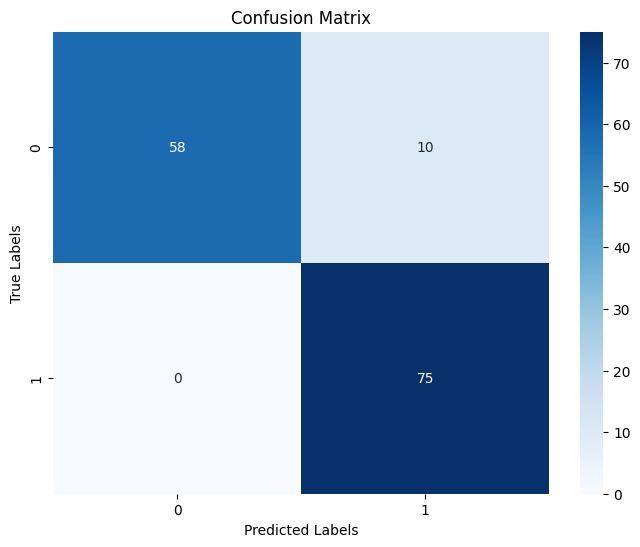

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        68
           1       0.88      1.00      0.94        75

    accuracy                           0.93       143
   macro avg       0.94      0.93      0.93       143
weighted avg       0.94      0.93      0.93       143



In [243]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'model' is your trained Keras model and X_test, y_test are your data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print the classification report
print(classification_report(y_true_classes, y_pred_classes))


## Experiment 3: RNN (LSTM model)
Out of curiosity I also wanted to test a RNN-based model on my data because I though could be temporal features of accents that can be captured by it.

The RNN LSTM model described in the code is a type of recurrent neural network that is particularly well-suited for sequential data, like audio for accent classification. LSTMs are capable of learning long-term dependencies and can remember information for an extended period, which is essential for capturing the nuances in speech patterns that differentiate accents.

In this model, LSTM layers are used to process the audio data sequentially, capturing the temporal features that are indicative of accents. These features are then passed through fully connected (Dense) layers to interpret these features and perform the classification.

Here's a point-wise description of each layer:

1. LSTM(64, return_sequences=True): An LSTM layer with 64 units. return_sequences=True ensures that the output for each timestep is returned, which is necessary for stacking LSTM layers.
2. LSTM(64): Another LSTM layer with 64 units that receives the sequence of outputs from the previous LSTM layer, further refining the model's understanding of the sequence data.
3. Dropout(0.2): A Dropout layer that randomly sets a fraction (20% here) of the input units to 0 at each update during training time, which helps prevent overfitting.
4. Dense(128, activation='relu'): A fully connected layer with 128 units and the ReLU activation function, which introduces non-linearity into the model, allowing it to learn more complex patterns.
6. Dropout(0.1): Another Dropout layer, this time with a 10% dropout rate, providing additional regularization.
7.Dense(2, activation='sigmoid'): The output layer, with two units (one for each class in binary classification). It uses the sigmoid activation function to output probabilities for each class.

## Code for RNN model training

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Test loss: 0.6970178484916687
Test accuracy: 0.4958677589893341


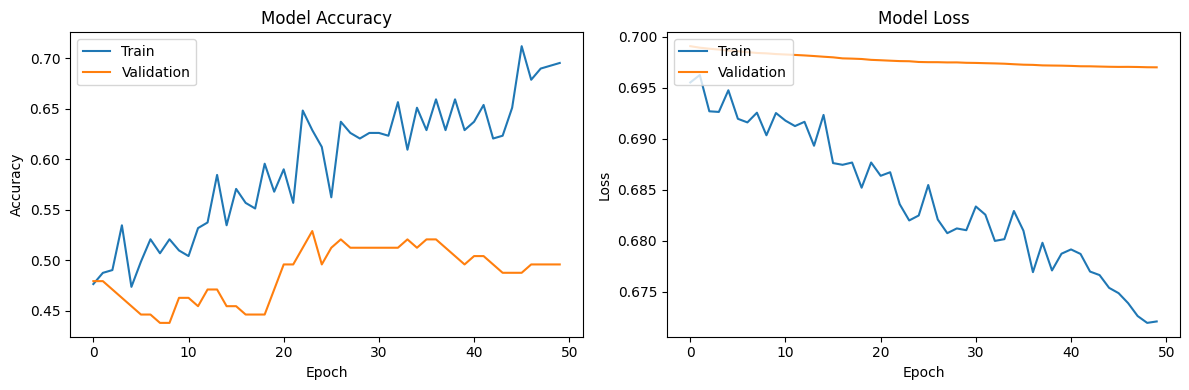

In [248]:
# Function to extract MFCC features from the dataset
def extract_features(df, audio_folder):
    X = []
    y = []
    for index, row in df.iterrows():
        file_path = os.path.join(audio_folder, row["fname"])
        label = row["label"]
        signal, sample_rate = librosa.load(file_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40)
        X.append(mfccs)
        y.append(1 if label == 'Argentinian' else 0)
    return np.array(X), np.array(y)

# Load the dataset and extract features
audio_folder = '/content/drive/MyDrive/CS156DATA/AUDIOCLIPS/'
df = pd.read_csv('/content/drive/MyDrive/CS156DATA/AUDIOLABELS/audio_files_labels.csv')
X, y = extract_features(df, audio_folder)

# Reshape the data for CNN input
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

# Define the undersampler
undersample = RandomUnderSampler(random_state=42)

# Flatten X for undersampling, then reshape it back after undersampling
X_flat = X.reshape(X.shape[0], -1)
X_resampled, y_resampled = undersample.fit_resample(X_flat, y)
X_resampled = X_resampled.reshape(X_resampled.shape[0], X.shape[1], X.shape[2], 1)

# One-hot encode the labels
y_resampled = to_categorical(y_resampled, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

from keras.layers import LSTM
# Define a simple RNN model with LSTM layers
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))

# Specify the learning rate
learning_rate = 0.00001  # Example learning rate

# Instantiate the optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=50,
    shuffle=True,
    validation_data=(X_test, y_test),
    verbose=0,  # Turn off the progress bar for cleaner output
    callbacks=[TqdmCallback(verbose=1)]  # Use TqdmCallback for progress bar
)

# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Code for RNN model metric and predictions
From the accuracy and test loss plots above and the confusion matrics below we can see the RNN (LSTM) performed really bad on the classification task with ~ 50% test accuracy and big difference between training and test accuracy (indicative of heavy overfitting).

4/4 [==============================] - 0s 5ms/step


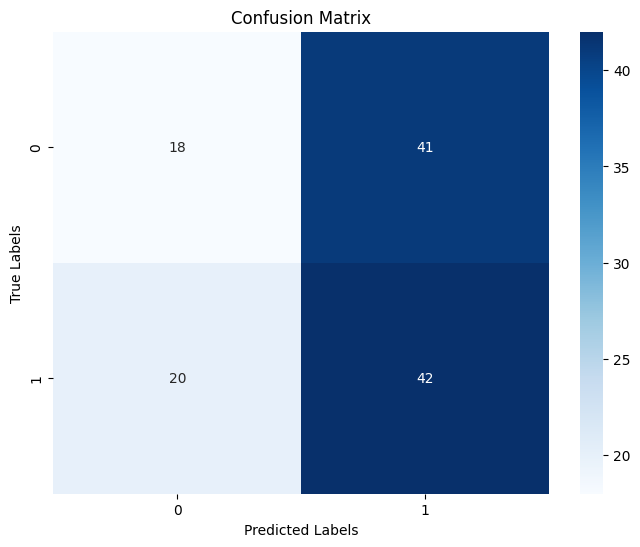

              precision    recall  f1-score   support

           0       0.47      0.31      0.37        59
           1       0.51      0.68      0.58        62

    accuracy                           0.50       121
   macro avg       0.49      0.49      0.48       121
weighted avg       0.49      0.50      0.48       121



In [250]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'model' is your trained Keras model and X_test, y_test are your data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print the classification report
print(classification_report(y_true_classes, y_pred_classes))


## 9: Executive Summary

In this second assignment I was able to build on my first assignment by increasing the size of my training data using data augmentation techniques and using CNN and RNN on MFCC images of the audio clips. I achieved significant increase in my test accuracy using the CNN model without the augmented data. Surprisingly the CNN model with augmented data did not perform as well as the CNN without the augmented data but that can be because of unoptimized hyperparameter choices and wrong choice of data augmentation techniques. Finally, the RNN (LSTM) model performed the worst and that can be because there are no temporal information in the MFCCs features of the audio clips and hence it was not able to learn meaningful patterns in the data.

Model Accuracy summary:

1. Losgictic Regression: 62%
2. Random Forest: 82%
3. CNN without data augmentation: 95%
4. CNN with data augmentation: 93%
5. RNN(LSTM):50%

CNN without data augmentation is the best model so far.

## References
Joshua, S. A. (2023, August 22). Revealing the harmonic domain: CNN and MFCC for music genre classification. Medium. https://medium.com/@joshuamts1234/revealing-the-harmonic-domain-cnn-and-mfcc-for-music-genre-classification-ffa3abbb4c39

Mittal, A. (2021, August 26). Understanding RNN and LSTM. Medium. https://aditi-mittal.medium.com/understanding-rnn-and-lstm-f7cdf6dfc14e

YouTube. (2018, October 24). DSP background - deep learning for audio classification P.1. YouTube. https://www.youtube.com/watch?v=Z7YM-HAz-IY&list=PLhA3b2k8R3t2Ng1WW_7MiXeh1pfQJQi_P

**AI Statement:** I utilized AI for writing the code, commenting the code, and creating docstrings throughout this assignment. While it wasn't always accurate, consulting library documentation helped me correct inaccuracies and deepen my understanding of the code and its associated terms.


In [252]:
!jupyter nbconvert --to pdf /content/sample_data/CS156P2FINAL.ipynb


[NbConvertApp] Converting notebook /content/sample_data/CS156P2FINAL.ipynb to pdf
[WARNING] Could not parse YAML metadata at line 6 column 1: not an object
[WARNING] Could not parse YAML metadata at line 16 column 1: Unexpected '<'
[NbConvertApp] Support files will be in CS156P2FINAL_files/
[NbConvertApp] Making directory ./CS156P2FINAL_files
[NbConvertApp] Making directory ./CS156P2FINAL_files
[NbConvertApp] Making directory ./CS156P2FINAL_files
[NbConvertApp] Making directory ./CS156P2FINAL_files
[NbConvertApp] Making directory ./CS156P2FINAL_files
[NbConvertApp] Making directory ./CS156P2FINAL_files
[NbConvertApp] Making directory ./CS156P2FINAL_files
[NbConvertApp] Writing 106936 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfu